In [287]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import shutil
import subprocess
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import LabelEncoder 

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical

from keras.models import load_model
from collections import Counter
import keras_cv


import datetime
import shap
from tensorflow.keras.utils import plot_model

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Conv2DTranspose, Cropping2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MeanIoU, Accuracy, BinaryAccuracy, MeanAbsoluteError, Recall, Precision
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras import layers, models

In [4]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [5]:
image_dest_path = os.path.join(working_path, 'data', 'Images')
image_dataset_path = image_dest_path

csv_path = os.path.join(working_path, 'data', 'csv')

In [6]:
csv_bounding_boxes = (f'{csv_path}\\PCB_annotations_dataset.csv')
images = os.listdir(image_dataset_path)

In [7]:
bounding_boxes_data = pd.read_csv(csv_bounding_boxes, sep=";")

In [8]:
bounding_boxes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885 entries, 0 to 4884
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4885 non-null   object
 1   width     4885 non-null   int64 
 2   height    4885 non-null   int64 
 3   depth     4885 non-null   int64 
 4   defect    4885 non-null   object
 5   xmin      4885 non-null   int64 
 6   xmax      4885 non-null   int64 
 7   ymin      4885 non-null   int64 
 8   ymax      4885 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 343.6+ KB


In [9]:
# Function to convert bounding box coordinates to vgg16 format
def convert_bbox_to_vgg16(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = ((box[0] + box[1]) / 2.0 - 1) * dw
    y = ((box[2] + box[3]) / 2.0 - 1) * dh
    w = (box[1] - box[0]) * dw
    h = (box[3] - box[2]) * dh
    return (x, y, w, h)


In [10]:
vgg16_labels_path = os.path.join(working_path, 'data', 'vgg16_labels')
os.makedirs(vgg16_labels_path, exist_ok=True)

In [11]:
unique_class_ids = bounding_boxes_data['defect'].unique()

In [12]:
encoder = LabelEncoder()

In [13]:
# Fit the encoder on unique class IDs
encoder.fit(unique_class_ids)

LabelEncoder()

In [ ]:
for filename, group in bounding_boxes_data.groupby('filename'):
    image_path = os.path.join(image_dataset_path, f"{filename}.jpg")
    image = cv2.imread(image_path)
    
    if image is not None:
        h, w, _ = image.shape
        size = (w, h)
        
        label_file_path = os.path.join(vgg16_labels_path, f"{os.path.splitext(filename)[0]}.txt")
        
        with open(label_file_path, 'w') as label_file:
        
            encoded_class_ids = encoder.transform(group['defect'])
            
            for class_id, (_, row) in zip(encoded_class_ids, group.iterrows()):
                bbox = (row['xmin'], row['xmax'], row['ymin'], row['ymax'])
                vgg16_bbox = convert_bbox_to_vgg16(size, bbox)
                label_file.write(f"{class_id} {' '.join(map(str, vgg16_bbox))}\n")
    else:
        print(f"Image {filename} not found.")

print("vgg16 annotations have been successfully created.")

In [15]:
vgg16_image_train_path = os.path.join(working_path, 'data', 'vgg16_data', 'images', 'train')
vgg16_image_val_path = os.path.join(working_path, 'data', 'vgg16_data', 'images', 'val')
vgg16_label_train_path = os.path.join(working_path, 'data', 'vgg16_data', 'labels', 'train')
vgg16_label_val_path = os.path.join(working_path, 'data', 'vgg16_data', 'labels', 'val')

os.makedirs(vgg16_image_train_path, exist_ok=True)
os.makedirs(vgg16_image_val_path, exist_ok=True)
os.makedirs(vgg16_label_train_path, exist_ok=True)
os.makedirs(vgg16_label_val_path, exist_ok=True)

In [16]:
image_files = [f for f in os.listdir(image_dataset_path) if f.endswith('.jpg')]

In [17]:
image_files = [f for f in os.listdir(image_dataset_path) if f.endswith('.jpg') and os.path.splitext(f)[0] in bounding_boxes_data['filename'].values]

In [18]:
print(len(image_files))

1799


In [19]:
max_files_per_class = 100

random.shuffle(image_files)

defect_names = ["missing_hole_", "spur_", "spurious_copper_", "short_", "open_circuit_", "mouse_bite_"]

image_counts = defaultdict(int)
train_counts = defaultdict(int)
val_counts = defaultdict(int)

# Extract defect class from the filename
def get_defect_class(filename):
    for defect in defect_names:
        if defect in filename:
            return defect
    return "unknown"

grouped_images = defaultdict(list)
for image_file in image_files:
    defect_class = get_defect_class(image_file)
    #grouped_images[defect_class].append(image_file)
    defect_class = get_defect_class(image_file)
    if image_counts[defect_class] < max_files_per_class:
        grouped_images[defect_class].append(image_file)
        image_counts[defect_class] += 1
    else:
        continue

train_files = []
val_files = []


for defect_class, images in grouped_images.items():
    train_size = int(0.8 * len(images))
    train_files.extend(images[:train_size])
    val_files.extend(images[train_size:])

    train_counts[defect_class] += len(images[:train_size])
    val_counts[defect_class] += len(images[train_size:])

print(f"Training")
for defect_class, count in train_counts.items():
    print(f"{defect_class}: {count} files")

print(f"===========================")
print(f"Validation")
for defect_class, count in val_counts.items():
    print(f"{defect_class}: {count} files")


Training
spur_: 80 files
open_circuit_: 80 files
short_: 80 files
spurious_copper_: 80 files
missing_hole_: 80 files
mouse_bite_: 80 files
Validation
spur_: 20 files
open_circuit_: 20 files
short_: 20 files
spurious_copper_: 20 files
missing_hole_: 20 files
mouse_bite_: 20 files


In [20]:
def delete_all_files(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

In [21]:
delete_all_files(vgg16_image_train_path)
delete_all_files(vgg16_image_val_path)
delete_all_files(vgg16_label_train_path)
delete_all_files(vgg16_label_val_path)


In [22]:
def copy_files(file_list, src_image_path, src_label_path, dst_image_path, dst_label_path):
    for filename in file_list:
        src_image = os.path.join(src_image_path, filename)
        dst_image = os.path.join(dst_image_path, filename)
        
        if os.path.exists(src_image):
            shutil.copyfile(src_image, dst_image)
        else:
            print(f"Source image {src_image} does not exist.")

        label_filename = filename.replace('.jpg', '.txt')
        src_label = os.path.join(src_label_path, label_filename)
        dst_label = os.path.join(dst_label_path, label_filename)

        if os.path.exists(src_label):
            shutil.copyfile(src_label, dst_label)
        else:
            print(f"Source label {src_label} does not exist.")

copy_files(train_files, image_dataset_path, vgg16_labels_path, vgg16_image_train_path, vgg16_label_train_path)
copy_files(val_files, image_dataset_path, vgg16_labels_path, vgg16_image_val_path, vgg16_label_val_path)

print(f"Copied {len(train_files)} training files and {len(val_files)} validation files.")

Copied 480 training files and 120 validation files.


In [23]:
# verify the copied files
train_images_copied = os.listdir(vgg16_image_train_path)
val_images_copied = os.listdir(vgg16_image_val_path)
train_labels_copied = os.listdir(vgg16_label_train_path)
val_labels_copied = os.listdir(vgg16_label_val_path)

print(f"Training images copied: {len(train_images_copied)}")
print(f"Validation images copied: {len(val_images_copied)}")
print(f"Training labels copied: {len(train_labels_copied)}")
print(f"Validation labels copied: {len(val_labels_copied)}")

Training images copied: 480
Validation images copied: 120
Training labels copied: 480
Validation labels copied: 120


In [24]:
val_labels_count = os.listdir(vgg16_labels_path)

print(f"Total labels: {len(val_labels_count)}")

Total labels: 2308


Model structure for VGG16_UNET

In [247]:
def VGG16_UNET_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # VGG16 base model for classification
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    vgg16_base_output = vgg16_base.output
    
    # Custom Classification architecture
    flatten_c = Flatten()(vgg16_base_output)
    fc1 = Dense(512, activation='relu')(flatten_c)
    dropout1 = layers.Dropout(0.5)(fc1)
    fc2 = Dense(128, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(fc2)

    # Classification Output
    classification_output = Dense(num_classes, activation='softmax', name='classification_output')(dropout2)

    # UNet-like architecture
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Model
    model = Model(inputs=inputs, 
                  outputs=[segmentation_output, classification_output])
    
    #uncomment the code below for 1st training
    for layer in vgg16_base.layers:#initially freeze the pre trained layers of VGG16 so that it learns on our dataset features
        layer.trainable = False 
        
    #uncomment the code below for 2nd training
    #for layer in vgg16_base.layers[-4:]: # unfreezing last 4 layers of VGG16
    #    layer.trainable = True
    
    return model

In [248]:
input_shape = (224, 224, 3)
num_classes = 6
model = VGG16_UNET_model(input_shape, num_classes)


Dataset preparation 

In [205]:
def resize_image(image_path, target_size=(224, 224)):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at path: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unable to read image file: {image_path}")
    img_resized = cv2.resize(img, target_size)  # Resize to VGG16 input size
    return img_resized

In [206]:
def parse_label_file(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        boxes = []
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x, y, w, h = map(float, parts[1:])
            boxes.append((label, x, y, w, h))
    return boxes

In [207]:
def generate_masks(img_shape, boxes):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    for box in boxes:
        label, x, y, w, h = box
        xmin = int((x - w/2) * img_shape[1])
        xmax = int((x + w/2) * img_shape[1])
        ymin = int((y - h/2) * img_shape[0])
        ymax = int((y + h/2) * img_shape[0])
        mask[ymin:ymax, xmin:xmax] = 1
    return mask, label

In [208]:
def prepare_data(image_files, vgg16_image_train_path, vgg16_label_train_path):
    images = []
    masks = []
    labels = []
    for filename in image_files:
        image_path = os.path.join(vgg16_image_train_path, filename)
        label_file = os.path.join(vgg16_label_train_path, os.path.splitext(filename)[0] + '.txt')
        if os.path.exists(image_path) and os.path.exists(label_file):
            image = resize_image(image_path)
            #print(image.shape)
            boxes = parse_label_file(label_file)
            mask, label = generate_masks(image.shape, boxes)
            images.append(image)
            masks.append(mask)
            labels.append(label)
    return np.array(images), np.array(masks), np.array(labels)


In [209]:
image_files_train = [f for f in os.listdir(vgg16_image_train_path) if f.endswith('.jpg')]

# Prepare training data
X_train, y_train_mask, y_train_label = prepare_data(image_files_train, vgg16_image_train_path, vgg16_label_train_path)
y_train_mask = np.expand_dims(y_train_mask, axis=-1)
y_train_label_encoded = to_categorical(y_train_label, num_classes=num_classes)


In [210]:
image_files_val = [f for f in os.listdir(vgg16_image_val_path) if f.endswith('.jpg')]

# Prepare validation data
X_val, y_val_mask, y_val_label = prepare_data(image_files_val, vgg16_image_val_path, vgg16_label_val_path)
y_val_mask = np.expand_dims(y_val_mask, axis=-1)
y_val_label_encoded = to_categorical(y_val_label, num_classes=num_classes)

In [259]:
print(f"Expected model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

print(f"X_train shape: {X_train.shape}")
print(f"y_train_mask shape: {y_train_mask.shape}")
print(f"y_train_label shape: {y_train_label.shape}")
print(f"One-hot encoded y_train_label shape: {y_train_label_encoded.shape}, dtype: {y_train_label_encoded.dtype}")

print(f"X_val shape: {X_val.shape}")
print(f"y_val_mask shape: {y_val_mask.shape}")
print(f"y_val__label shape: {y_val_label.shape}")
print(f"One-hot encoded y_val_label shape: {y_val_label_encoded.shape}, dtype: {y_val_label_encoded.dtype}")


Expected model input shape: (None, 224, 224, 3)
Model output shape: [(None, 224, 224, 1), (None, 6)]
X_train shape: (480, 224, 224, 3)
y_train_mask shape: (480, 224, 224, 1)
y_train_label shape: (480,)
One-hot encoded y_train_label shape: (480, 6), dtype: float64
X_val shape: (120, 224, 224, 3)
y_val_mask shape: (120, 224, 224, 1)
y_val__label shape: (120,)
One-hot encoded y_val_label shape: (120, 6), dtype: float64


Albumentations for data augmentation

In [236]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=1), 
    #A.RandomCrop(height=224, width=224, p=1), # excluding because it might crop the defect area
    A.Rotate(limit=90, p=1),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.GaussianBlur(p=1),
    #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50, p=1),
    #A.RandomSunFlare(p=1),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),
    A.Resize(width=224, height=224),  # to ensure the final size is 224x224 for VGG16
], additional_targets={'mask': 'mask'})

augment_factor = len(transform.transforms)

In [237]:
def augment_data(images, masks, labels, transform, augment_factor=3):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for img, mask, label in zip(images, masks, labels):
        for _ in range(augment_factor):
            transformed = transform(image=img, mask=mask)
            augmented_images.append(transformed['image'])
            augmented_masks.append(transformed['mask'])
            augmented_labels.append(label)  # No augmentation needed for labels

    return np.array(augmented_images), np.array(augmented_masks), np.array(augmented_labels)


In [225]:
def augment_single_image(image, mask, transform):
    transformed = transform(image=image, mask=mask)
    return transformed['image'], transformed['mask']

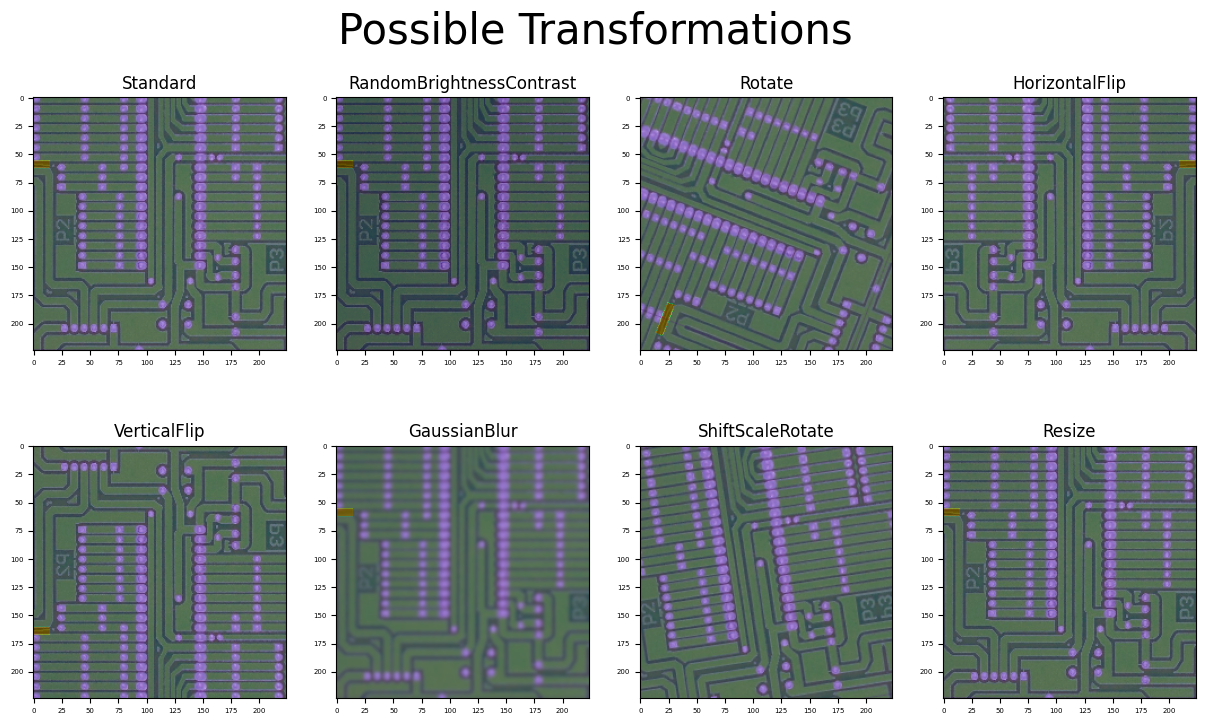

In [226]:
j = np.random.randint(0, len(X_train))

plt.figure(figsize=(15, 8))
plt.suptitle("Possible Transformations", fontsize=30)
plt.subplots_adjust(hspace=0.3)

# Original image and mask
ax1 = plt.subplot(2, 4, 1)
ax1.tick_params(labelsize=5)
im = X_train[j]
mask = y_train_mask[j]
plt.imshow(im)
plt.imshow(mask, alpha=0.3, cmap='rainbow')
plt.title("Standard")

# Apply each transformation and plot the result
for i, transf in enumerate(transform.transforms):
    ax = plt.subplot(2, 4, i + 2)
    ax.tick_params(labelsize=5)
    aug = A.Compose([transf, A.Resize(width=224, height=224)])
    trans_im, trans_mask = augment_single_image(im, mask, aug)
    plt.imshow(trans_im)
    plt.imshow(trans_mask, alpha=0.3, cmap='rainbow')
    plt.title(transf.__class__.__name__)

plt.show()

In [238]:
X_train_aug, y_train_mask_aug, y_train_label_encoded_aug = augment_data(X_train, y_train_mask, y_train_label_encoded, transform, augment_factor)


In [239]:
X_train_aug = X_train_aug.astype('float32') / 255.0
y_train_label_encoded_aug = y_train_label_encoded_aug.astype('float32')

In [240]:
print(f"X_train_aug shape: {X_train_aug.shape}")
print(f"y_train_mask_aug shape: {y_train_mask_aug.shape}")
print(f"y_train_label_encoded_aug shape: {y_train_label_encoded_aug.shape}")
print(f"dtype: {y_train_label_encoded_aug.dtype}")

X_train_aug shape: (3360, 224, 224, 3)
y_train_mask_aug shape: (3360, 224, 224, 1)
y_train_label_encoded_aug shape: (3360, 6)
dtype: float32


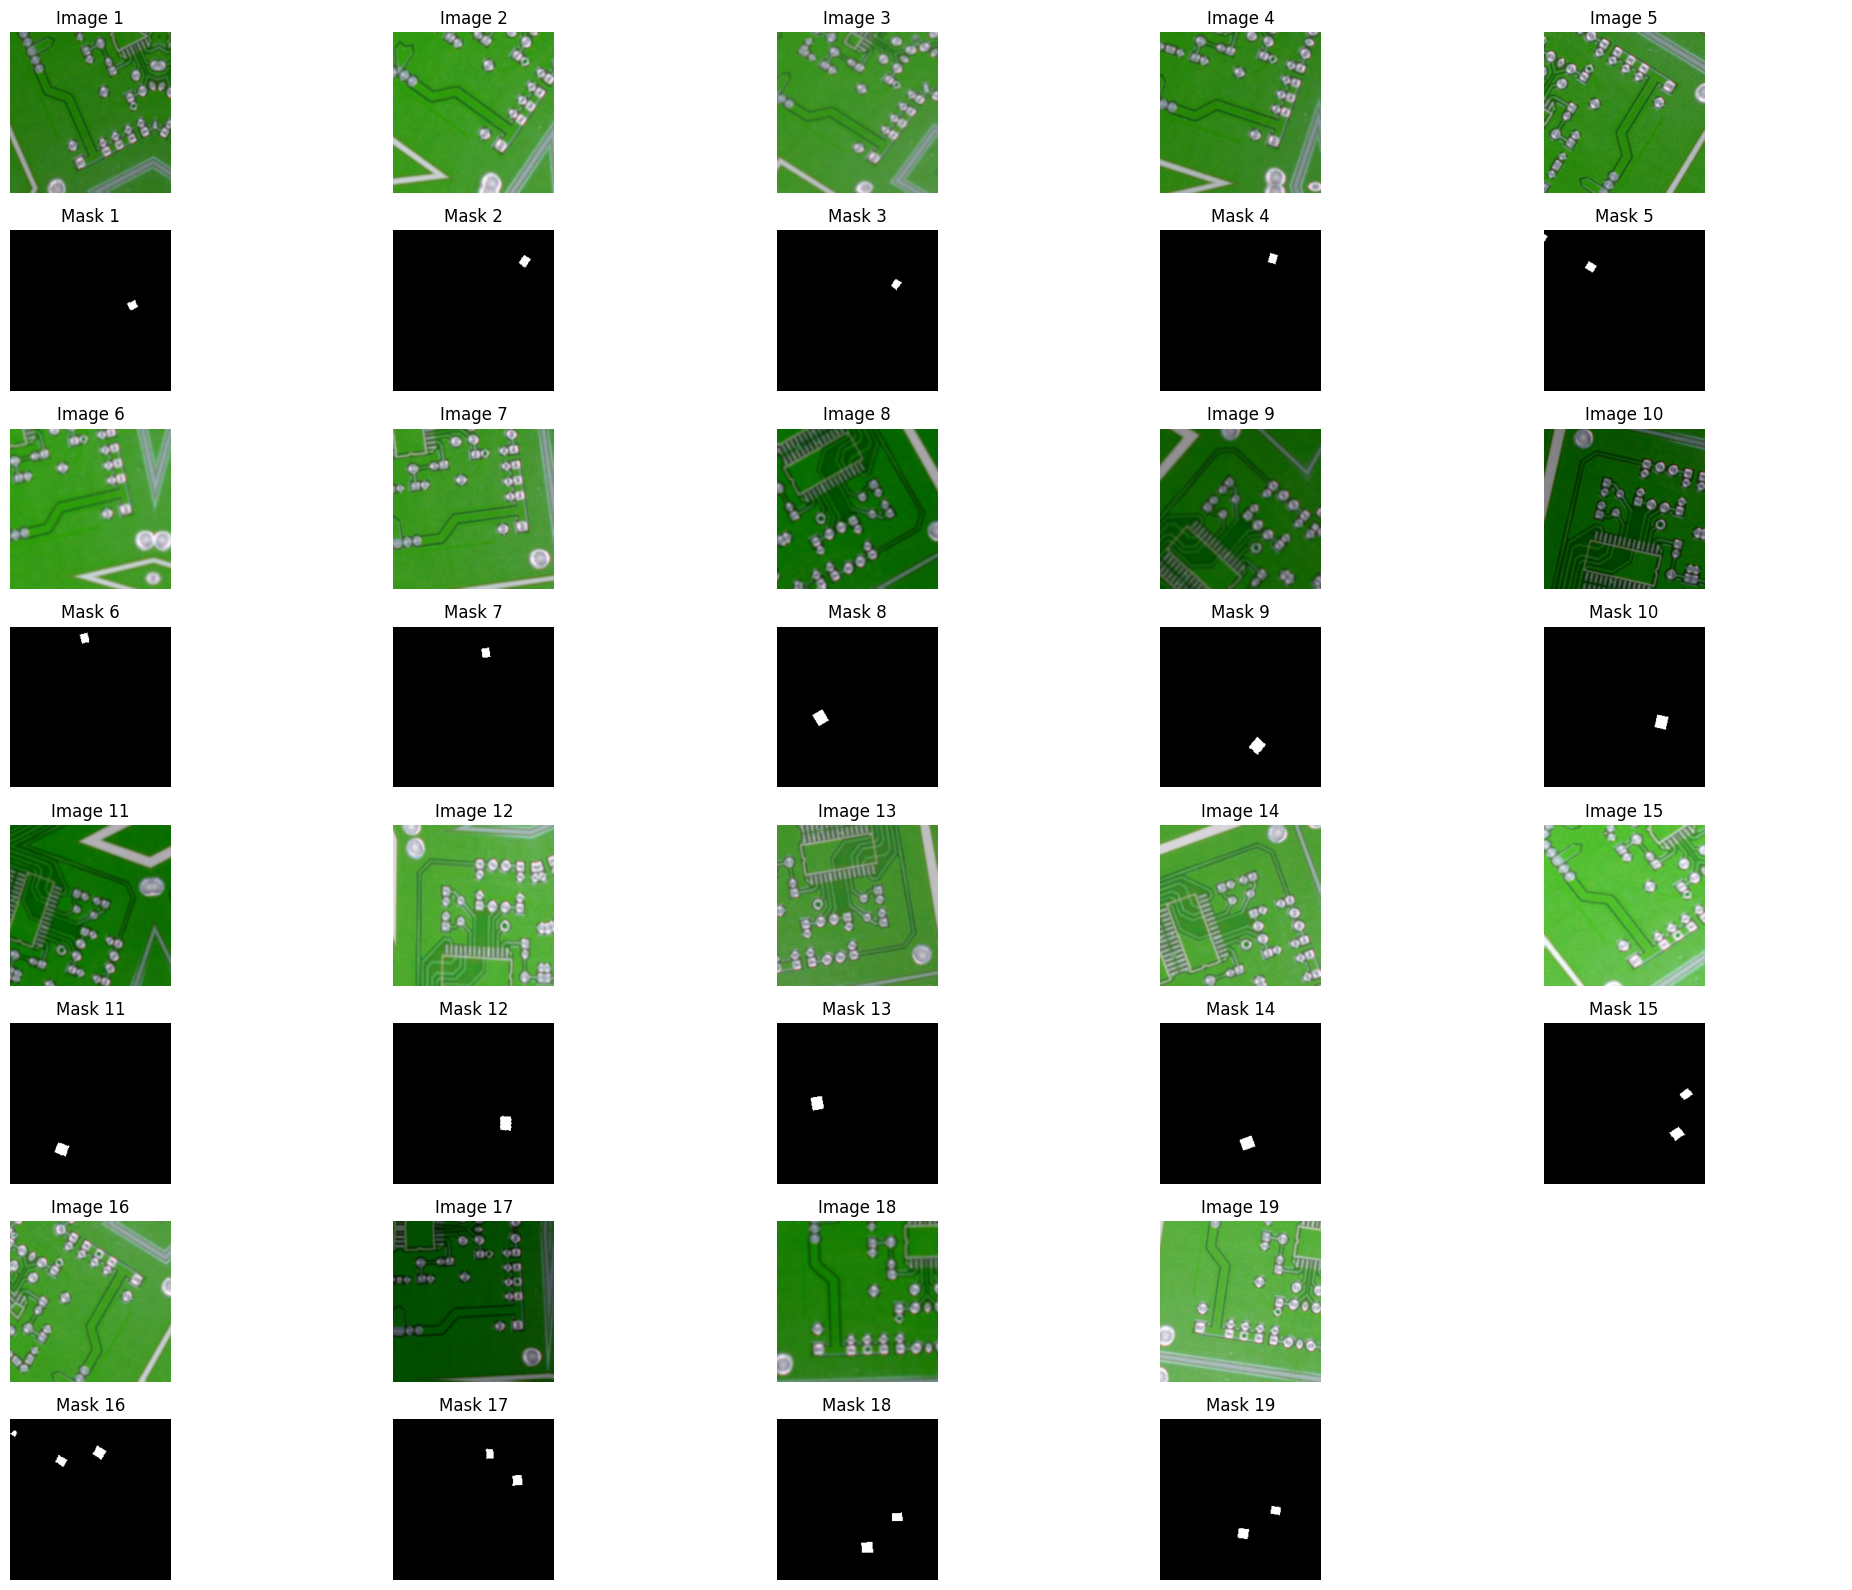

In [254]:
def display_augmented_images(images, masks, num_images=15):
    images_per_row = 5
    rows = ((num_images // images_per_row) + (1 if num_images % images_per_row != 0 else 0)) * 2 
    cols = images_per_row
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2))

    for i in range(num_images):
        row = (i // images_per_row) * 2
        col = i % images_per_row
        
        axes[row, col].imshow(images[i])
        axes[row, col].set_title(f'Image {i + 1}')
        axes[row, col].axis('off')

        axes[row + 1, col].imshow(masks[i].squeeze(), cmap='gray')
        axes[row + 1, col].set_title(f'Mask {i + 1}')
        axes[row + 1, col].axis('off')
    
    # Hiding unused subplots when images dont fill the row
    for j in range(num_images, rows * cols // 2):
        row = (j // images_per_row) * 2
        col = j % images_per_row
        axes[row, col].axis('off')
        axes[row + 1, col].axis('off')

    plt.tight_layout()
    plt.show()

display_augmented_images(X_train_aug, y_train_mask_aug, num_images=19)

In [199]:
# Compile the model
model.compile(optimizer='adam',#Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', Recall(), Precision()])

In [256]:
# Compile model
model.compile(optimizer='adam',#SGD(learning_rate=0.001, momentum=0.9),
              loss={'segmentation_output': 'binary_crossentropy', 'classification_output': 'categorical_crossentropy'},
              loss_weights={'segmentation_output': 0.2,  # initially Weighted at 80%, 20%, 100%
                            'classification_output': 0.8 },  # initially Weighted at 20%, 80%. 0%
              metrics={'segmentation_output': ['accuracy', MeanAbsoluteError(), MeanIoU(num_classes=num_classes)],
                       'classification_output': ['accuracy', Recall(), Precision()]})


In [257]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_7[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_62[0][0] 

 Total params: 29,489,543 (112.49 MB)

 Trainable params: 14,774,855 (56.36 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [258]:
plot_model(model, to_file='vgg16_unet_model.png', show_shapes=True, show_layer_names=True);

In [263]:
# Train model
history = model.fit(x=X_train_aug, 
                    y=[y_train_mask_aug, y_train_label_encoded_aug],
                    validation_data=(X_val, [y_val_mask, y_val_label_encoded]),
                    epochs=8, batch_size=32,
                    verbose=True)

Epoch 1/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 2259s 22s/step - classification_output_accuracy: 0.1776 - classification_output_precision_11: 0.1668 - classification_output_recall_11: 0.0773 - loss: 2.5873 - segmentation_output_accuracy: 0.9946 - segmentation_output_mean_absolute_error: 0.0124 - segmentation_output_mean_io_u_6: 0.4973 - val_classification_output_accuracy: 0.1750 - val_classification_output_precision_11: 0.1683 - val_classification_output_recall_11: 0.1417 - val_loss: 5.2436 - val_segmentation_output_accuracy: 0.9935 - val_segmentation_output_mean_absolute_error: 0.0065 - val_segmentation_output_mean_io_u_6: 0.4968
Epoch 2/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 2237s 21s/step - classification_output_accuracy: 0.1569 - classification_output_precision_11: 0.1956 - classification_output_recall_11: 8.2413e-04 - loss: 1.4466 - segmentation_output_accuracy: 0.9945 - segmentation_output_mean_absolute_error: 0.0113 - segmentation_output_mean_io_u_6: 0.4972 - val_classification_output_accuracy: 

In [264]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_vgg16_unet-v240625.csv', index=False)
model.save('model_vgg16_unet-v240625.keras')

In [265]:
print(history.history.keys())

dict_keys(['classification_output_accuracy', 'classification_output_precision_11', 'classification_output_recall_11', 'loss', 'segmentation_output_accuracy', 'segmentation_output_mean_absolute_error', 'segmentation_output_mean_io_u_6', 'val_classification_output_accuracy', 'val_classification_output_precision_11', 'val_classification_output_recall_11', 'val_loss', 'val_segmentation_output_accuracy', 'val_segmentation_output_mean_absolute_error', 'val_segmentation_output_mean_io_u_6'])


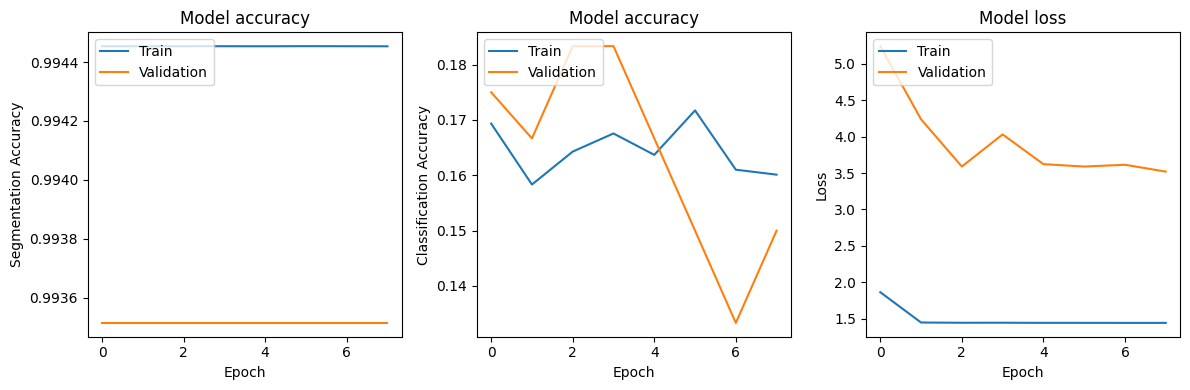

In [268]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['segmentation_output_accuracy'])
plt.plot(history.history['val_segmentation_output_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Segmentation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['classification_output_accuracy'])
plt.plot(history.history['val_classification_output_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Classification Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [271]:
# testing
results = model.evaluate(X_val, [y_val_mask, y_val_label_encoded])



4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - classification_output_accuracy: 0.1256 - classification_output_precision_11: 0.1235 - classification_output_recall_11: 0.0763 - loss: 3.4385 - segmentation_output_accuracy: 0.9938 - segmentation_output_mean_absolute_error: 0.0062 - segmentation_output_mean_io_u_6: 0.4969


In [281]:
def predict_and_visualize(model, image_path, label_path):
    image = resize_image(image_path)
    boxes = parse_label_file(label_path)
    gt_mask, gt_label = generate_masks(image.shape, boxes)
    #mask = mask_tuple[0]  
    pred_mask, pred_label = model.predict(np.expand_dims(image, axis=0))
    
    #pred_mask = np.squeeze(pred_mask)
    
    pred_label = np.argmax(pred_label, axis=-1)
    # Print shapes and types to debug
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {gt_mask.shape} type: {type(gt_mask)}")
    print(f"Predicted mask shape: {pred_mask.shape} type: {type(pred_mask)}")
    
    # Visualize the results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image label:  {gt_label}')
    plt.imshow(image)
    #plt.imshow(gt_mask, alpha=0.3, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title(f'Ground Truth Mask: {gt_label}')
    plt.imshow(gt_mask, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title(f'Predicted Mask, label: {pred_label[0]})')
    plt.imshow(pred_mask.squeeze())
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Image shape: (224, 224, 3)
Mask shape: (224, 224) type: <class 'numpy.ndarray'>
Predicted mask shape: (1, 224, 224, 1) type: <class 'numpy.ndarray'>


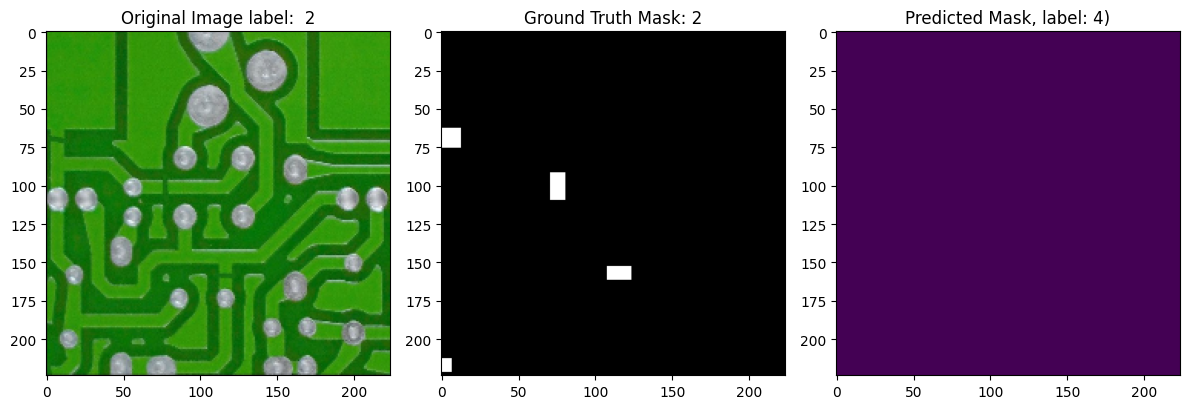

In [282]:
test_image = 'rotation_270_light_10_open_circuit_06_5_600.jpg'
test_label = 'rotation_270_light_10_open_circuit_06_5_600.txt'
image_path_test = os.path.join(vgg16_image_val_path, test_image)
label_file_test = os.path.join(vgg16_label_val_path, os.path.splitext(test_label)[0] + '.txt')

predict_and_visualize(model, image_path_test, label_file_test)

In [288]:
y_pred_mask, y_pred_class_cat = model.predict(X_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


In [ ]:
"missing_hole_", "spur_", "spurious_copper_", "short_", "open_circuit_", "mouse_bite_"

In [290]:
labels = ['missing hole',
          'spur',
          'spurious copper',
          'short',
          'open circuit',
          'mouse_bite'  
          ]
y_val_label = np.asarray(list(map(lambda cat: labels[np.argmax(cat)], y_val_label_encoded)))
y_pred_class = np.asarray(list(map(lambda cat: labels[np.argmax(cat)], y_pred_class_cat)))
y_pred_confidence = np.asarray(list(map(lambda cat: np.max(cat), y_pred_class_cat)))

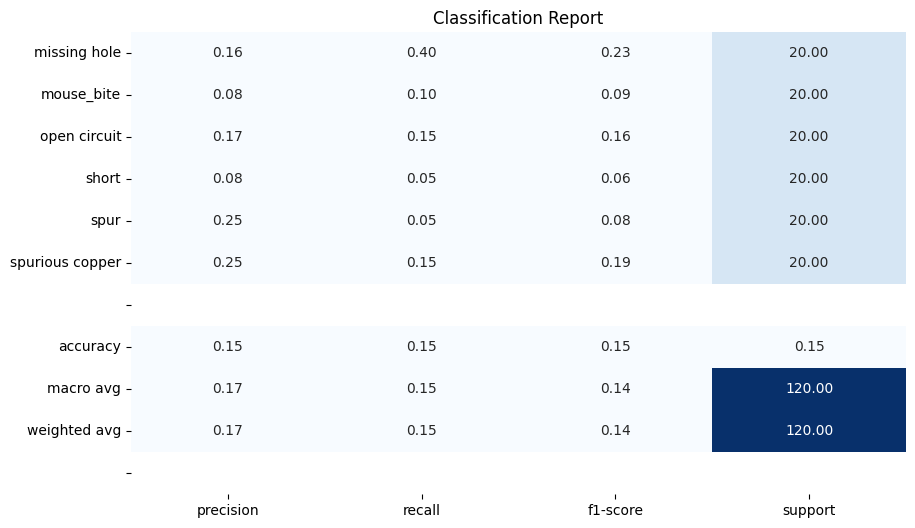

In [291]:
report = classification_report(y_val_label, y_pred_class, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df.loc[''] = np.nan

idx = list(report_df.index)
sep_idx = idx.index('accuracy')
new_idx = idx[:sep_idx] + [''] + idx[sep_idx:]
report_df = report_df.loc[new_idx]

plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Classification Report')
plt.show()

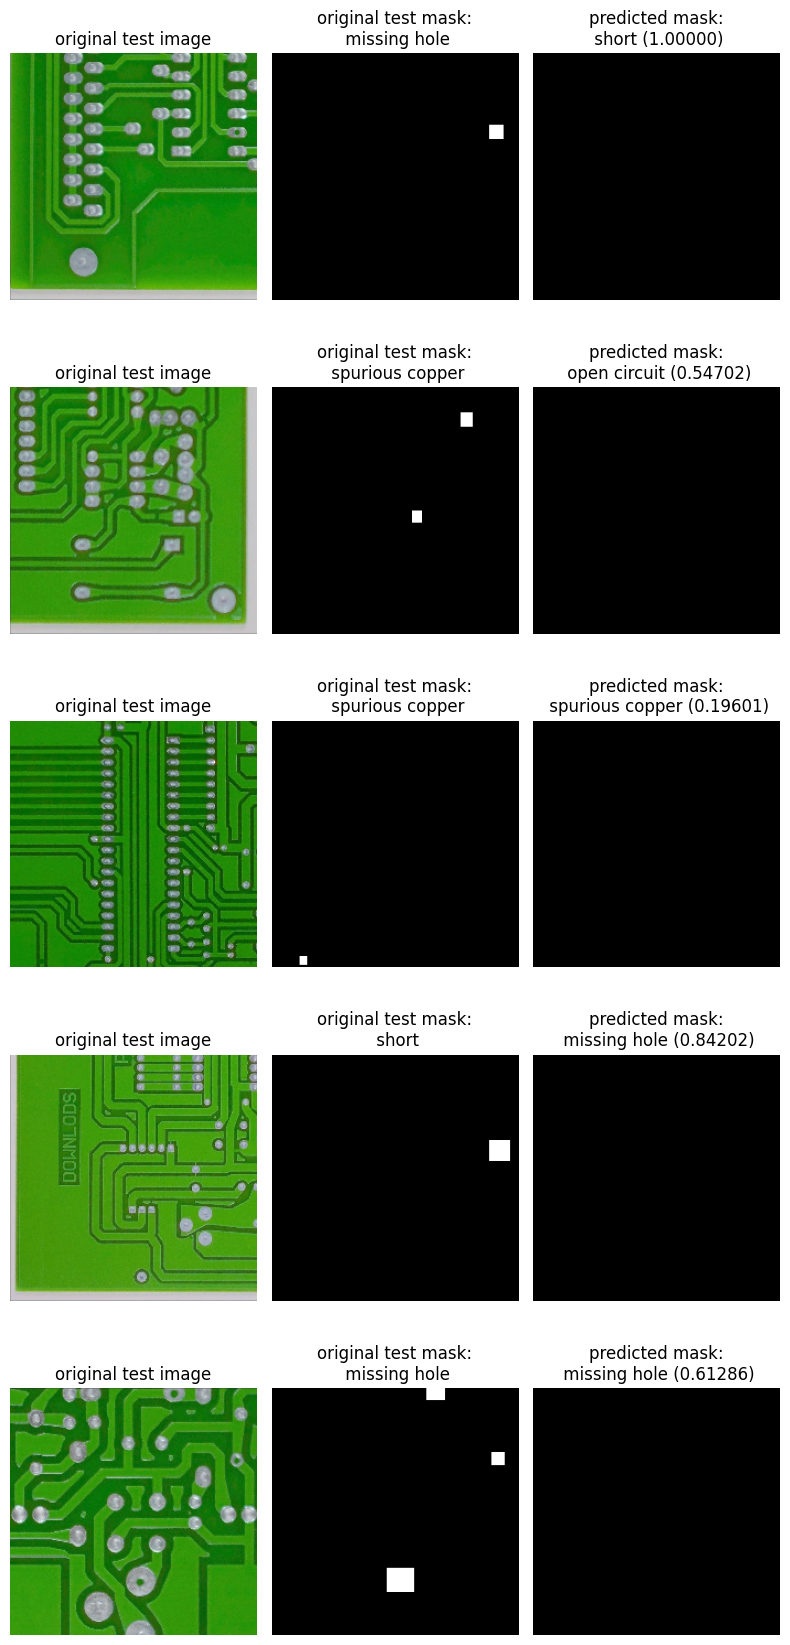

In [292]:
rnd = np.random.choice(X_val.shape[0], 5)
fig, ax = plt.subplots(5, 3, figsize=(8,25))
ax = ax.flatten()
for i in range(rnd.shape[0]):
    confidence = y_pred_confidence[rnd[i]]
    ax[3*i].imshow(X_val[rnd[i]].squeeze(), cmap='gray')
    ax[3*i].set_title('original test image')
    ax[3*i].set_axis_off()
    ax[3*i+1].imshow(y_val_mask[rnd[i]].squeeze(), cmap='gray')
    ax[3*i+1].set_title(f'original test mask:\n {y_val_label[rnd[i]]}')
    ax[3*i+1].set_axis_off()
    ax[3*i+2].imshow(y_pred_mask[rnd[i]].squeeze(), cmap='gray')
    ax[3*i+2].set_title(f'predicted mask:\n {y_pred_class[rnd[i]]} ({confidence:.5f})');
    ax[3*i+2].set_axis_off()
fig.tight_layout(h_pad=-50)

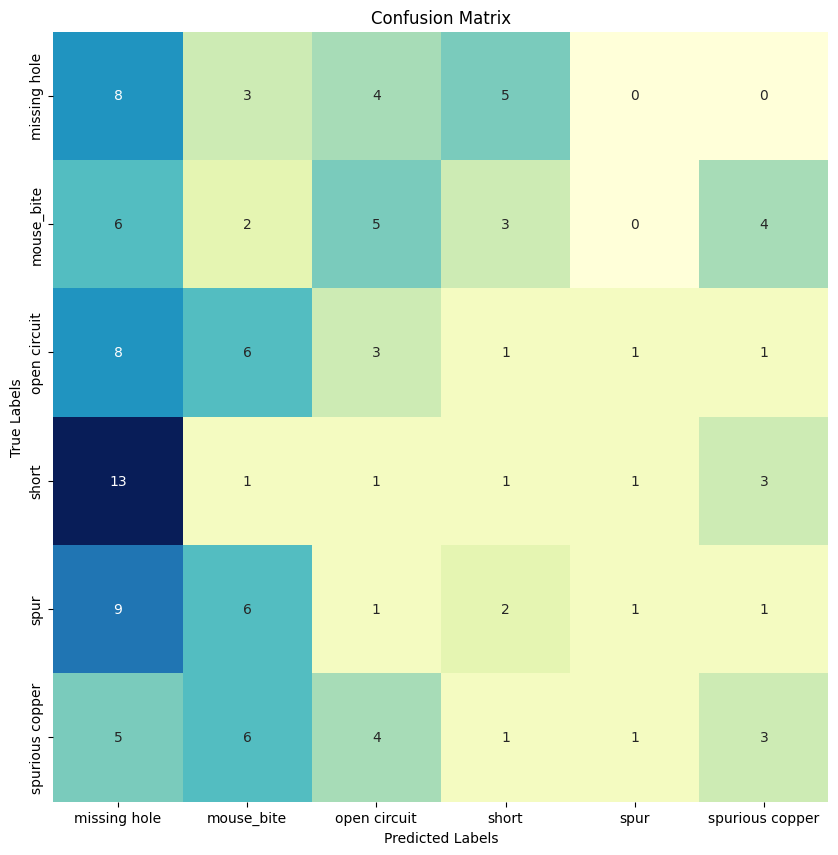

In [293]:
crosstab = pd.crosstab(y_val_label, y_pred_class)
plt.figure(figsize=(10, 10))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_path = 'model_vgg16_unet-v240625.keras'
'''
custom_objects = {
    #'focal_loss_fixed': focal_loss_fixed,
    #'DiceLoss': DiceLoss,
    'BinaryFocalCrossentropy': BinaryFocalCrossentropy,
    'CategoricalFocalCrossentropy': CategoricalFocalCrossentropy
}
'''
#model = load_model(model_path)#, custom_objects=custom_objects)

model = load_model(model_path, custom_objects={
    'MeanAbsoluteError': MeanAbsoluteError,
    'MeanIoU': MeanIoU,
    'Recall': Recall,
    'Precision': Precision
})